In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd

In [ ]:
# Load datasets
movies_metadata = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
ratings = pd.read_csv('/kaggle/input/the-movies-dataset/ratings.csv')
# Load the credits data
credits = pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv')

/tmp/ipykernel_47/886477026.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')


In [ ]:
# Convert the 'id' in movies_metadata and 'movieId' in ratings to the same type
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')
ratings['movieId'] = ratings['movieId'].astype('float64')

# Dropping any rows with NaNs that were created due to conversion errors
movies_metadata = movies_metadata.dropna(subset=['id'])
ratings = ratings.dropna(subset=['movieId'])

# Merging datasets
merged_data = pd.merge(movies_metadata, ratings, left_on='id', right_on='movieId').copy()
merged_data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,userId,movieId,rating,timestamp
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1923,862.0,3.0,858335006
1,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,2103,862.0,5.0,946044912
2,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,5380,862.0,1.0,878941641
3,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,6177,862.0,4.0,859415226
4,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,6525,862.0,4.0,857388995


In [ ]:
# Example of handling missing values
merged_data.fillna(method='ffill', inplace=True)
merged_data = merged_data[merged_data['budget'] != '0']


/tmp/ipykernel_47/8175913.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


In [ ]:
def process_genres(genres_str):
    """
    Process the genres column to count the number of genres.
    :param genres_str: A JSON-like string representing genres.
    :return: The count of genres.
    """
    try:
        genres = json.loads(genres_str.replace("'", '"'))
        return len(genres)
    except json.JSONDecodeError:
        return 0

def process_production_companies(companies_str):
    """
    Process the production_companies column to count the number of companies.
    :param companies_str: A JSON-like string representing production companies.
    :return: The count of production companies.
    """
    try:
        companies = json.loads(companies_str.replace("'", '"'))
        return len(companies)
    except json.JSONDecodeError:
        return 0


In [ ]:
print(merged_data.columns)


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'userId', 'movieId', 'rating',
       'timestamp'],
      dtype='object')


In [ ]:
merged_data['num_genres'] = merged_data['genres'].apply(process_genres)
merged_data['num_production_companies'] = merged_data['production_companies'].apply(process_production_companies)

# Processing release_date
merged_data['release_year'] = pd.to_datetime(merged_data['release_date']).dt.year
merged_data['release_month'] = pd.to_datetime(merged_data['release_date']).dt.month
merged_data['release_day'] = pd.to_datetime(merged_data['release_date']).dt.day

# Defining numerical and categorical features
numeric_features = ['vote_average', 'budget', 'num_genres', 'num_production_companies', 'release_year', 'release_month', 'release_day']


In [ ]:
# Combine numeric and categorical features
features = numeric_features

# Define targets
target = ['rating', 'popularity']

merged_data.dropna(subset=target, inplace=True)
print("NaN in Targets:", merged_data[target].isna().sum())


NaN in Targets: rating        0
popularity    0
dtype: int64


In [ ]:
merged_data['budget']

0           30000000
1           30000000
2           30000000
3           30000000
4           30000000
              ...   
11435785     1200000
11435786     1200000
11435787     1200000
11435788     1200000
11435789     1200000
Name: budget, Length: 6379672, dtype: object

In [ ]:
X_lr = merged_data[features]  # Features for linear regression models

# Splitting the data for ratings prediction (Linear Regression)
X_train_lr, X_temp_lr, y_train_ratings, y_temp_ratings = train_test_split(X_lr, merged_data['rating'], test_size=0.3, random_state=42)
X_test_ratings_lr, X_val_ratings_lr, y_test_ratings_lr, y_val_ratings_lr = train_test_split(X_temp_lr, y_temp_ratings, test_size=0.5, random_state=42)

# Splitting the data for popularity prediction (Linear Regression)
X_train_lr, X_temp_lr, y_train_popularity, y_temp_popularity = train_test_split(X_lr, merged_data['popularity'], test_size=0.3, random_state=42)
X_test_popularity_lr, X_val_popularity_lr, y_test_popularity_lr, y_val_popularity_lr = train_test_split(X_temp_lr, y_temp_popularity, test_size=0.5, random_state=42)


In [ ]:
X_train_lr['budget']

7602348      1000000
4053385     25000000
1722333     36000000
978776       2500000
1754317    160000000
             ...    
2108411     92620000
3010408      4300000
7672219      8000000
6448081     28000000
2237017     10000000
Name: budget, Length: 4465770, dtype: object

In [ ]:
X_train_lr.head()

,vote_average,budget,num_genres,num_production_companies,release_year,release_month,release_day
7602348,6.9,1000000,1,1,2004,2,10
4053385,6.8,25000000,3,3,2000,12,14
1722333,6.6,36000000,3,3,1997,5,2
978776,7.6,2500000,2,2,1967,7,18
1754317,4.1,160000000,3,2,1997,6,13


In [ ]:
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# Scaling features
scaler = StandardScaler()
X_train_lr_scaled = scaler.fit_transform(X_train_lr)
X_val_ratings_lr_scaled = scaler.transform(X_val_ratings_lr)

# Convert to PyTorch tensors for training data
x_tensor = torch.tensor(X_train_lr_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train_ratings.values, dtype=torch.float32).view(-1, 1)

# Convert to PyTorch tensors for validation data
x_val_ratings_tensor = torch.tensor(X_val_ratings_lr_scaled, dtype=torch.float32)
y_val_ratings_tensor = torch.tensor(y_val_ratings_lr.values, dtype=torch.float32).view(-1, 1)

# optimizer_model1 = optim.Adam(model1.parameters(), lr=0.001)

# Linear Regression Model in PyTorch
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()  # Initialize the base class
        self.linear = nn.Linear(7, 1)

    def forward(self, x):
        x = self.linear(x)
        return x

model1 = LinearRegressionModel()

# Loss Function and Optimizer with adjusted learning rate
criterion = nn.MSELoss()
optimizer_model1 = optim.SGD(model1.parameters(), lr=0.001, weight_decay=0.00001, momentum=0.9, nesterov=True)

# Define a threshold for accuracy (e.g., 10%)
accuracy_threshold = 0.15

# Initialize lists to store metrics
train_losses, val_losses, train_mse_list, val_mse_list, train_accuracy_list, val_accuracy_list = [], [], [], [], [], []

# Training loop for model1
for epoch in range(100):
    model1.train()
    # Forward pass
    pred_y_train = model1(x_tensor.clone())
    train_loss = criterion(pred_y_train, y_tensor)

    # Calculate training accuracy
    train_accuracy = ((torch.abs(pred_y_train - y_tensor) / y_tensor) < accuracy_threshold).float().mean().item()

    # Backward pass and optimization
    optimizer_model1.zero_grad()
    train_loss.backward()
    optimizer_model1.step()

    model1.eval()
    # Validation
    with torch.no_grad():
        pred_y_val = model1(x_val_ratings_tensor.clone())
        val_loss = criterion(pred_y_val, y_val_ratings_tensor)

        # Calculate validation accuracy
        val_accuracy = ((torch.abs(pred_y_val - y_val_ratings_tensor) / y_val_ratings_tensor) < accuracy_threshold).float().mean().item()

    # Update lists to store metrics
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accuracy_list.append(train_accuracy)
    val_accuracy_list.append(val_accuracy)

    # Print metrics
    print(f'Epoch {epoch + 1}, Training Loss: {train_loss.item()}, Training Accuracy: {train_accuracy * 100:.2f}%, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy * 100:.2f}%')


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

Epoch 1, Training Loss: 14.663145065307617, Training Accuracy: 13.16%, Validation Loss: 14.613007545471191, Validation Accuracy: 13.73%
Epoch 2, Training Loss: 14.60914134979248, Training Accuracy: 14.17%, Validation Loss: 14.559211730957031, Validation Accuracy: 15.09%
Epoch 3, Training Loss: 14.5553560256958, Training Accuracy: 15.46%, Validation Loss: 14.505633354187012, Validation Accuracy: 15.37%
Epoch 4, Training Loss: 14.501786231994629, Training Accuracy: 15.75%, Validation Loss: 14.45226764678955, Validation Accuracy: 15.30%
Epoch 5, Training Loss: 14.448429107666016, Training Accuracy: 15.64%, Validation Loss: 14.399115562438965, Validation Accuracy: 15.34%
Epoch 6, Training Loss: 14.39528751373291, Training Accuracy: 15.68%, Validation Loss: 14.346179008483887, Validation Accuracy: 15.44%
Epoch 7, Training Loss: 14.342357635498047, Training Accuracy: 15.87%, Validation Loss: 14.293453216552734, Validation Accuracy: 15.18%
Epoch 8, Training Loss: 14.289642333984375, Training 

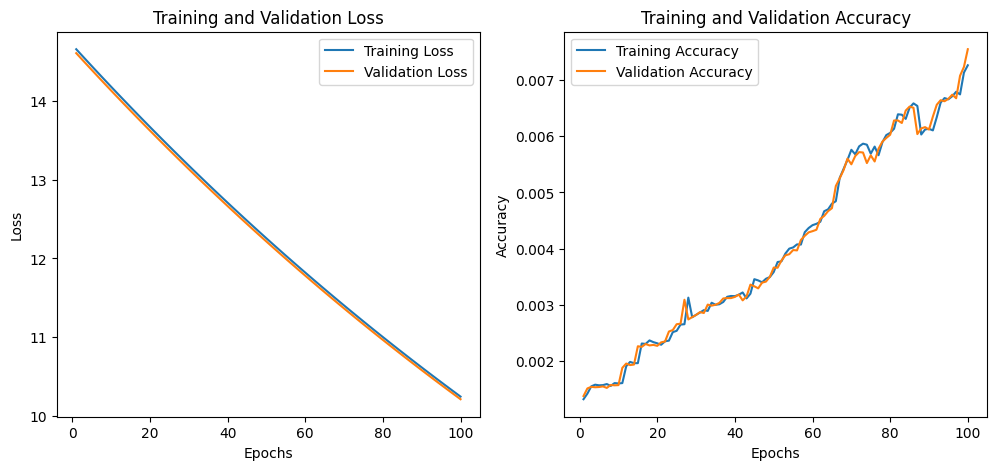

In [ ]:
# Plotting
epochs = range(1, 101)
plt.figure(figsize=(12, 5))

# Plot for losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Scaling features for popularity prediction
scaler_popularity = StandardScaler()
X_train_popularity_scaled = scaler_popularity.fit_transform(X_train_lr)
X_val_popularity_lr_scaled = scaler_popularity.transform(X_val_popularity_lr)

# Convert to PyTorch tensors
x_popularity_tensor = torch.tensor(X_train_popularity_scaled, dtype=torch.float32)

# Convert y_train_popularity to numeric, setting errors to 'coerce' which converts non-numeric values to NaN
y_train_popularity_numeric = pd.to_numeric(y_train_popularity, errors='coerce')

# Handling missing values (if any) in y_train_popularity
y_train_popularity_numeric.fillna(y_train_popularity_numeric.mean(), inplace=True)

# Convert to PyTorch tensor
y_popularity_tensor = torch.tensor(y_train_popularity_numeric.values, dtype=torch.float32).view(-1, 1)

# Instantiate a new model for popularity prediction
model2 = LinearRegressionModel()

# Loss Function and Optimizer for the popularity model
criterion_popularity = nn.MSELoss()

# optimizer_model1 = optim.Adam(model1.parameters(), lr=0.001).
optimizer_popularity = optim.SGD(model2.parameters(), lr=0.001, weight_decay=0.00001)  # Reduced learning rate

x_val_popularity_tensor = torch.tensor(X_val_popularity_lr_scaled, dtype=torch.float32)

# Convert y_val_popularity_lr to numeric, setting errors to 'coerce' which converts non-numeric values to NaN
y_val_popularity_lr_numeric = pd.to_numeric(y_val_popularity_lr, errors='coerce')

# Fill NaNs with the mean
y_val_popularity_lr_numeric.fillna(y_val_popularity_lr_numeric.mean(), inplace=True)

# Convert to PyTorch tensor
y_val_popularity_tensor = torch.tensor(y_val_popularity_lr_numeric.values, dtype=torch.float32).view(-1, 1)

# Initialize lists to store metrics
train_losses, val_losses, train_acc, val_acc = [], [], [], []

# Define a threshold for accuracy (e.g., 10%)
accuracy_threshold = 0.15

# Training loop for the popularity model
for epoch in range(100):
    model2.train()  # Set model2 to training mode

    # Forward pass and loss calculation for the training data
    pred_popularity_train = model2(x_popularity_tensor.clone())  # Cloning the tensor
    train_loss_popularity = criterion_popularity(pred_popularity_train, y_popularity_tensor)

    # Calculate training accuracy
    train_accuracy = ((torch.abs(pred_popularity_train - y_popularity_tensor) / y_popularity_tensor) < accuracy_threshold).float().mean().item()

    # Backward pass and optimization
    optimizer_popularity.zero_grad()
    train_loss_popularity.backward()
    optimizer_popularity.step()

    model2.eval()  # Set model2 to evaluation mode
    # Forward pass for validation data
    with torch.no_grad():
        pred_popularity_val = model2(x_val_popularity_tensor.clone())  # Cloning the tensor for validation
        val_loss_popularity = criterion_popularity(pred_popularity_val, y_val_popularity_tensor)

        # Calculate validation accuracy
        val_accuracy = ((torch.abs(pred_popularity_val - y_val_popularity_tensor) / y_val_popularity_tensor) < accuracy_threshold).float().mean().item()

    # Calculate training and validation metrics for popularity
    #train_mse_popularity = mean_squared_error(y_popularity_tensor.detach().numpy(), pred_popularity_train.detach().numpy())
    train_r2_popularity = r2_score(y_popularity_tensor.detach().numpy(), pred_popularity_train.detach().numpy())
    #val_mse_popularity = mean_squared_error(y_val_popularity_tensor.detach().numpy(), pred_popularity_val.detach().numpy())
    val_r2_popularity = r2_score(y_val_popularity_tensor.detach().numpy(), pred_popularity_val.detach().numpy())

    # Print training and validation metrics
    print(f'Epoch {epoch + 1}, '
          f'Popularity Training Loss: {train_loss_popularity.item()}, '
          f'Training R2: {train_r2_popularity}, '
          f'Validation Loss: {val_loss_popularity.item()}, '
          f'Validation R2: {val_r2_popularity}, ')

    # Append metrics to lists
    train_losses.append(train_loss_popularity.item())
    val_losses.append(val_loss_popularity.item())
    train_acc.append(train_r2_popularity)
    val_acc.append(val_r2_popularity)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

Epoch 1, Popularity Training Loss: 165.93374633789062, Training R2: -2.5458190390711373, Validation Loss: 164.77279663085938, Validation R2: -2.572376256004347, 
Epoch 2, Popularity Training Loss: 165.4060516357422, Training R2: -2.534542560584928, Validation Loss: 164.24685668945312, Validation R2: -2.5609741899392575, 
Epoch 3, Popularity Training Loss: 164.88043212890625, Training R2: -2.5233107719162335, Validation Loss: 163.7230224609375, Validation R2: -2.549617322952083, 
Epoch 4, Popularity Training Loss: 164.35690307617188, Training R2: -2.5121234996075104, Validation Loss: 163.2012939453125, Validation R2: -2.53830558014264, 
Epoch 5, Popularity Training Loss: 163.83544921875, Training R2: -2.5009806698604753, Validation Loss: 162.68161010742188, Validation R2: -2.5270387487431316, 
Epoch 6, Popularity Training Loss: 163.31605529785156, Training R2: -2.4898820756375697, Validation Loss: 162.16400146484375, Validation R2: -2.515816575725466, 
Epoch 7, Popularity Training Loss:

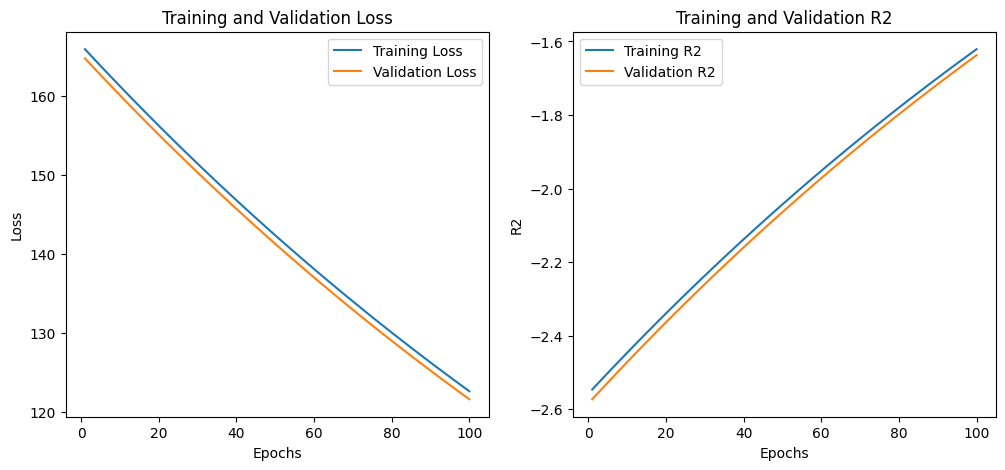

In [ ]:
# Plotting
epochs = range(1, 101)
plt.figure(figsize=(12, 5))

# Plot for losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for R2
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training R2')
plt.plot(epochs, val_acc, label='Validation R2')
plt.title('Training and Validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()

plt.show()

In [ ]:
# Scaling the test data for ratings and popularity
X_test_ratings_scaled = scaler.transform(X_test_ratings_lr)
X_test_popularity_scaled = scaler_popularity.transform(X_test_popularity_lr)

# Convert the scaled test data to tensors
x_test_ratings_tensor = torch.tensor(X_test_ratings_scaled, dtype=torch.float32)
x_test_popularity_tensor = torch.tensor(X_test_popularity_scaled, dtype=torch.float32)

# Put models in evaluation mode
model1.eval()
model2.eval()

# Make predictions with no gradient calculations
with torch.no_grad():
    y_test_pred_ratings_tensor = model1(x_test_ratings_tensor)
    y_test_pred_popularity_tensor = model2(x_test_popularity_tensor)

# Convert predictions to numpy arrays
y_test_pred_ratings = y_test_pred_ratings_tensor.view(-1).numpy()
y_test_pred_popularity = y_test_pred_popularity_tensor.view(-1).numpy()

# Calculate Mean Squared Error for both models
mse_ratings_test = mean_squared_error(y_test_ratings_lr, y_test_pred_ratings)
mse_popularity_test = mean_squared_error(y_test_popularity_lr, y_test_pred_popularity)

print(f'MSE for Ratings on Test Set: {mse_ratings_test}')
print(f'MSE for Popularity on Test Set: {mse_popularity_test}')


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

MSE for Ratings on Test Set: 10.206192279057541
MSE for Popularity on Test Set: 122.29364477502021


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [ ]:
from ast import literal_eval

def parse_cast(cast_str):
    try:
        # Convert the string representation of the list to an actual list
        cast_list = literal_eval(cast_str)
        return [(actor['name'], actor['id']) for actor in cast_list]
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing string: {e}")  # Print error for debugging
        return []

# Apply the function to the 'cast' column
credits['parsed_cast'] = credits['cast'].apply(parse_cast)

# Efficiently expand the 'parsed_cast' into a list of tuples
expanded_cast = []
for _, row in credits.iterrows():
    for actor in row['parsed_cast']:
        expanded_cast.append((actor[0], actor[1], row['id']))

expanded_cast_df = pd.DataFrame(expanded_cast, columns=['actor_name', 'actor_id', 'movie_id'])

In [ ]:
# Sample a subset of the data, e.g., 10% of the data to avoid kernel crashing
expanded_cast_df = expanded_cast_df.sample(frac=0.1, random_state=42)
sampled_data = merged_data.sample(frac=0.1, random_state=42)
new_data = pd.merge(expanded_cast_df, sampled_data, left_on='movie_id', right_on='movieId')

In [ ]:
print(new_data.head())

     actor_name  actor_id  movie_id  adult  \
0  Sal Richards   1237372       238  False   
1  Sal Richards   1237372       238  False   
2  Sal Richards   1237372       238  False   
3  Sal Richards   1237372       238  False   
4  Sal Richards   1237372       238  False   

                               belongs_to_collection   budget  \
0  {'id': 230, 'name': 'The Godfather Collection'...  6000000   
1  {'id': 230, 'name': 'The Godfather Collection'...  6000000   
2  {'id': 230, 'name': 'The Godfather Collection'...  6000000   
3  {'id': 230, 'name': 'The Godfather Collection'...  6000000   
4  {'id': 230, 'name': 'The Godfather Collection'...  6000000   

                                              genres  \
0  [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...   
1  [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...   
2  [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...   
3  [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...   
4  [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...

In [ ]:
# since only the features were scaled for training, the predicted values are in their original scale,
# so combining them directly could result in a biased representation where one variable dominates the calculation.
from sklearn.preprocessing import StandardScaler

# Extract the relevant columns
data_to_scale = new_data[['rating', 'popularity']]

# Apply standardization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Add scaled data back to the DataFrame
new_data[['scaled_rating', 'scaled_popularity']] = scaled_data

# Now calculate actor popularity using scaled values
new_data['actor_popularity'] = (0.5 * new_data['scaled_rating'] + 0.5 * new_data['scaled_popularity'] )

# Group by actor and aggregate actor popularity
actor_popularity = new_data.groupby('actor_id')['actor_popularity'].mean().reset_index()

# actor_popularity DataFrame now contains each actor's average popularity score

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

In [ ]:
print(actor_popularity)

      actor_id  actor_popularity
0            1         -0.257871
1            2          0.082363
2            3          0.377616
3            4          0.082363
4           10          0.361126
...        ...               ...
4250   1896892         -0.443258
4251   1899069         -0.992449
4252   1899142         -0.340660
4253   1901428         -0.070109
4254   1901430         -0.070109

[4255 rows x 2 columns]


In [ ]:
# Select the feature and target
X_nn = new_data[['actor_popularity']].values
y_nn = new_data['revenue'].values

# Scaling the feature
scaler_nn = StandardScaler()
X_scaled_nn = scaler_nn.fit_transform(X_nn)

# Splitting the dataset
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_scaled_nn, y_nn, test_size=0.2, random_state=42)

# Convert to PyTorch tensors for Neural Network
X_train_tensor_nn = torch.tensor(X_train_nn.astype(np.float32))
y_train_tensor_nn = torch.tensor(y_train_nn.astype(np.float32))
X_test_tensor_nn = torch.tensor(X_test_nn.astype(np.float32))
y_test_tensor_nn = torch.tensor(y_test_nn.astype(np.float32))

# Create DataLoader for batch processing for Neural Network
train_data_nn = TensorDataset(X_train_tensor_nn, y_train_tensor_nn)
train_loader_nn = DataLoader(train_data_nn, batch_size=32, shuffle=True)


In [ ]:
import torch.nn as nn

class RevenueNet(nn.Module):
    def __init__(self):
        super(RevenueNet, self).__init__()
        self.fc1 = nn.Linear(1, 10)  # 1 input neuron (actor_popularity) and 10 neurons in the first hidden layer
        self.fc2 = nn.Linear(10, 10)  # Second hidden layer
        self.fc3 = nn.Linear(10, 1)   # Output layer (1 neuron for predicting revenue)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function in the output layer for regression
        return x

net = RevenueNet()


In [ ]:
import torch.optim as optim

criterion_nn = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer_nn = optim.Adam(net.parameters(), lr=0.001)

# Neural Network Training loop
epoch_losses_nn = []
for epoch in range(100):  # Number of epochs
    running_loss_nn = 0.0
    for inputs_nn, labels_nn in train_loader_nn:
        optimizer_nn.zero_grad()
        outputs_nn = net(inputs_nn)
        loss_nn = criterion_nn(outputs_nn, labels_nn.view(-1, 1))
        loss_nn.backward()
        optimizer_nn.step()
        running_loss_nn += loss_nn.item()

    epoch_loss_nn = running_loss_nn / len(train_loader_nn)
    epoch_losses_nn.append(epoch_loss_nn)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss_nn}')


Epoch 1, Loss: 1.6509851223825792e+17
Epoch 2, Loss: 1.5766520108857773e+17
Epoch 3, Loss: 1.3811365430265034e+17
Epoch 4, Loss: 1.1638907888077853e+17
Epoch 5, Loss: 1.094259767951762e+17
Epoch 6, Loss: 1.0905181672793016e+17
Epoch 7, Loss: 1.0903585664833061e+17
Epoch 8, Loss: 1.0902725242768323e+17
Epoch 9, Loss: 1.0902094234560275e+17
Epoch 10, Loss: 1.0901814671230944e+17
Epoch 11, Loss: 1.0901383012447248e+17
Epoch 12, Loss: 1.0901017302035674e+17
Epoch 13, Loss: 1.0900786434637707e+17
Epoch 14, Loss: 1.0900193989081645e+17
Epoch 15, Loss: 1.0899779555209221e+17
Epoch 16, Loss: 1.0899003834340862e+17
Epoch 17, Loss: 1.0898409728532858e+17
Epoch 18, Loss: 1.0897105023209328e+17
Epoch 19, Loss: 1.0895910915345438e+17


In [ ]:
# Evaluate the model's performance on the test set
net.eval()
with torch.no_grad():
    predicted_nn = net(X_test_tensor_nn)
    test_loss_nn = criterion_nn(predicted_nn, y_test_tensor_nn.view(-1, 1))
    print(f'Test Loss: {test_loss_nn.item()}')

In [ ]:
# Optionally, plot the training loss over epochs
import matplotlib.pyplot as plt

plt.plot(range(1, 101), epoch_losses_nn)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [ ]:
def predict_revenue(input_features, model1, model2, net, scaler):
    # Scale input features
    #input_features_scaled = scaler.transform(input_features)

    # Convert scaled features to tensor
    input_features_tensor = torch.tensor(input_features, dtype=torch.float32)

    # Set models to evaluation mode
    model1.eval()
    model2.eval()

    # Make predictions with linear regression models
    with torch.no_grad():  # Disable gradient computation
        predicted_rating = model1(input_features_tensor)
        predicted_popularity = model2(input_features_tensor)

    # Calculate actor popularity
    actor_popularity = (0.5 * predicted_rating + 0.5 * predicted_popularity)

    # Predict with neural network
    net.eval()  # Set the network to evaluation mode
    with torch.no_grad():
        revenue_prediction = net(actor_popularity)

    return revenue_prediction.numpy().flatten()

# Example usage
#['vote_average', 'popularity', 'budget', 'num_genres', 'num_production_companies', 'release_year', 'release_month', 'release_day']
temp = [1, 1, 1, 1, 1, 1, 1, 1]
revenue_prediction = predict_revenue(temp, model1, model2, net, scaler)
print("your expected revenue is: ", revenue_prediction)


In [ ]:
def get_user_input():
    # List of features
    features = ['vote_average', 'popularity', 'budget', 'num_genres', 'num_production_companies', 'release_year', 'release_month', 'release_day']
    user_input = []

    # Ask the user for each feature
    for feature in features:
        # Input validation loop
        while True:
            try:
                value = float(input(f"Enter {feature}: "))
                user_input.append(value)
                break
            except ValueError:
                print("Invalid input. Please enter a numeric value.")

    return user_input

def predict_revenue(input_features, model1, model2, net, scaler):
    # Scale input features
    # input_features_scaled = scaler.transform([input_features])

    # Convert scaled (or unscaled if scaler is not used) features to tensor
    input_features_tensor = torch.tensor([input_features], dtype=torch.float32)  # Ensure input is 2D

    # Set models to evaluation mode
    model1.eval()
    model2.eval()

    # Make predictions with linear regression models
    with torch.no_grad():  # Disable gradient computation
        predicted_rating = model1(input_features_tensor)
        predicted_popularity = model2(input_features_tensor)

    # Calculate actor popularity
    actor_popularity = (0.5 * predicted_rating + 0.5 * predicted_popularity)

    # Predict with neural network
    net.eval()  # Set the network to evaluation mode
    with torch.no_grad():
        revenue_prediction = net(actor_popularity)

    return revenue_prediction.numpy().flatten()

# Get user input
user_input = get_user_input()

# Predict revenue
revenue_prediction = predict_revenue(user_input, model1, model2, net, scaler)
print("Your expected revenue is: ", revenue_prediction[0])

Enter vote_average:  7.7
Enter popularity:  26.4
Enter budget:  30000000
Enter num_genres:  3
Enter num_production_companies:  1
Enter release_year:  1995
Enter release_month:  10
Enter release_day:  30


Your expected revenue is:  2186236600000000.0
